# Vaccines Trade Network
### Author: Georgios Spyrou
### Date: 23/05/2020

<img src="https://www.our-voices.org.uk/assets/images/Network-diagram.png" width=720 height=400 />

## Project Puprose

Scope of this project is to construct the global trade network of vaccines around the globe for multiple years(current data span from 2017 to 2019. Through plotting and statistical analysis, we want to identify informative patterns on how different countries change their import/export activity of vaccines. 

## Part 1: Data Retrieval

In order to find and retrieve data we have utilised the UN Comtrade API (https://comtrade.un.org/Data/).This is a great place if someone wants to find data regarding exports/impors of countries around the world, pretty much for any product/service. The data are very well documented and visualized on the website, and it's easy to do some exploration  and locate data that seem interesting for your project.

Therefore, after I managed to identify the relevant data that I wanted to work with (vaccines for human medicine), I had to find a way to leverage the API to get my data. Even though the website allows us to download sample CSV files, if we wanted to do that for multiple years and countries it would take a lot of time. Hence, I have decided to approach the data retrival from a Python standpoint, in order to automate this task.

Before we jump to the part of how we are going to automate the data retrieval, it might worths it to explain what exactly we are aiming to retrieve.


The UN Comtrade database is giving us the opportunity to pick from a plethora of goods and services. My first task was to find the specific code that corresponds to human vaccines. After a bit of research we have found that this code is *300220*, which is a unique value that will allow us to only pick data for this good/product. After we located our product code, we have to decide on the time range that we want to pick data for. This can quickly get tricky as the database does not allow you to many years/countries all at once. But for now lets say that the scope of interest was *monthly* data from 2017 to 2019, for as many countries as possible - mainly because there are countries which do not seem to import/export vaccines or we do not have relevant information about them.

Now that are know pretty much what we are looking for, lets dive into creating some API calls in Python to automatically get the data.

In [1]:
import requests
import csv
import json
import time
import os

# Setting up the parameters for the API calls to receive the data

max_rec = 100000
output_fmt = 'csv'
trade_type = 'C'            # Commodities
frequency = 'M'             # Monthly
px = 'HS'                   # Classification for products
cc = 300220                 # Subcategory --> 300220 code for Vaccines
reporter = 'all'
partner = 'all'                 
rg ='all'

# Connection string to comtrade.un.org based on the parameters above
api_call_string = f'http://comtrade.un.org/api/get?max={max_rec}&type={trade_type}&freq={frequency}&px={px}&ps=year&r=reporter&p={partner}&rg={rg}&cc={cc}&fmt={output_fmt}'

After we have set up the string that will be used to do the appropriate API calls, it's time create a function that will use this string to retrieve the data and generate the csv files.

In [2]:
def getDataCall(api_string: str, reporterid: str, reportername: str, year: int, out_folder: str) -> None:
    '''
    Create a .csv file that contains the data as received from  https://comtrade.un.org/Data/, for a specific year.

    Args:
    ----
        api_string: String that contains the URL for the API call. The string already contains all the paremeters required for the call.
        reporter: Specify Reporter country.
        year: Specify year of interest.
    Returns:
    -------
        None: The output is a .csv file that contains the data for a specified year.
    '''
    csv_by_year_out_loc = os.path.join(out_folder, f'{year}')
    if not os.path.exists(csv_by_year_out_loc):
        os.makedirs(name=csv_by_year_out_loc)

    api_string = api_string.replace('year', f'{year}').replace('reporter', f'{reporterid}')
    print(api_string)

    response = requests.get(url=api_string)

    if response.status_code != 200:
        print('Could not access the API!')
    else:
        decoded_data = response.content.decode('utf-8')
        csv_file = csv.reader(decoded_data.splitlines())
        datalines = list(csv_file)

        with open(os.path.join(csv_by_year_out_loc, f'Comtrade_Vaccines_Data_{reportername}_{year}.csv'), 'w', newline='') as f:
            writer = csv.writer(f, delimiter=',')
            writer.writerows(datalines)

Note that this call will run for *each* country, therefore we will end up with a lot of csv files. The country codes can be found here: https://comtrade.un.org/Data/cache/reporterAreas.json

In [3]:
reporters_url = 'https://comtrade.un.org/Data/cache/partnerAreas.json'
reporters_resp = requests.get(url=reporters_url)
json_data = json.loads(reporters_resp.text)

reporters_list = [rep for rep in json_data['results']]

# Get the data as separate csv files, each for every year of interest
years_ls = [2017]
outputFilesFolder = f'CSVFiles\\'

In [ ]:
for api_check, repd in enumerate(reporters_list):
    # Need to make the script to sleep every 100 calls, as the API is blocking us for an hour for every 100 calls.
    if api_check !=0 and api_check % 100 == 0:
        time.sleep(3600)
    countryname = repd['text']
    c_id = repd['id']
    print(f'\nCountry..: {countryname}')
    for year in years_ls:
        print(f'\nReceiving the data for {year} from https://comtrade.un.org/...\n')
        getDataCall(api_call_string, reporterid=c_id, reportername=countryname, year=year, out_folder=outputFilesFolder)
        time.sleep(6)

At this point, we have successfully get the data for every country that we cound find a corresponding country code. That said, as we mentioned before there are some countries that contain no data for a specific year - which is might be for many reasons but this is out of the scope of this project. Hence, after we have ended up with multiple csv files , one for each country , we can repeat this process for as many years as we want to. I have repeated it three times (2017, 2018, 2019).

As you can probably imagine this process generated over 300 csv files (3 years x over 100 countries). Hence it was necessary to perform some data cleaning operations in the directory that the files were created. The main task was to merge all this files for a specific year (e.g. all countries for 2017 merged to a common csv file), and at the same time delete all the files from the directory that contained no data.

In order to do that we have created a script to automatically do this for us, but as it might not be that of an interesting task we are going to leave it outside of this notebook. That said, the code that completes this can be found here: https://github.com/gpsyrou/Vaccines_Trade_Network/blob/master/dataCleaning.py

## Part 2: Exploratory Data Analysis & Data Cleaning

Now that we have our data organized into separate csv files by year, we can start the task of exploring what we actually got from the data retriaval process. We will explore this by taking into consideration all the data from 2017 to 2019.

**Note**: Frow now on you are going to see two packages, one named Functions and one named VaccinesTradeNetworkClass. Please note that these are custom packages that I have created for the purposes of this project. The first one contains some functions that we will keep using for our EDA tasks, while the VaccinesTradeNetworkClass one will be used later on, when we jump into creating out network graph objects.

In [35]:
import os
import pandas as pd
import numpy as np

project_dir = 'C:\\Users\\george\\Desktop\\GitHub\\Projects\\Comtrade_Network'
os.chdir(project_dir)

import warnings
warnings.filterwarnings('ignore')

# Custom packages
from Functions import tradeNetworkFunctions as tnf
from VaccinesTradeNetworkClass import VaccinesTradeNetwork

# Plotting and graphs
import matplotlib.pyplot as plt
import seaborn as sns

csv_files_loc = os.path.join(project_dir, 'Merged_CSVs')
maindf = pd.concat([pd.read_csv(os.path.join(csv_files_loc, file)) for file in os.listdir(csv_files_loc)])

At this stage we need to explore the dataset and identify any potential issues in the data tha require cleaning, and also make sure that we understand the features.


In [36]:
summary = maindf.describe()
summary

,Year,Period,Aggregate Level,Is Leaf Code,Trade Flow Code,Reporter Code,Reporter ISO,Partner Code,Partner ISO,2nd Partner Code,...,Qty,Alt Qty Unit Code,Alt Qty Unit,Alt Qty,Netweight (kg),Gross weight (kg),Trade Value (US$),CIF Trade Value (US$),FOB Trade Value (US$),Flag
count,174733.000000,174733.000000,174733.0,174733.0,174733.000000,174733.000000,0.0,174733.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.459460e+05,0.0,1.747330e+05,0.0,0.0,174733.0
mean,2014.509721,201457.467548,6.0,1.0,1.573652,430.022137,NaN,383.477483,NaN,NaN,...,NaN,NaN,NaN,NaN,2.202360e+04,NaN,5.059609e+06,NaN,NaN,0.0
std,2.784246,278.388706,0.0,0.0,0.534287,269.904852,NaN,280.672337,NaN,NaN,...,NaN,NaN,NaN,NaN,1.922478e+06,NaN,3.375567e+07,NaN,NaN,0.0
min,2010.000000,201001.000000,6.0,1.0,1.000000,8.000000,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000000e+00,NaN,0.000000e+00,NaN,NaN,0.0
25%,2012.000000,201208.000000,6.0,1.0,1.000000,208.000000,NaN,124.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,5.000000e+01,NaN,1.596700e+04,NaN,NaN,0.0
50%,2015.000000,201502.000000,6.0,1.0,2.000000,392.000000,NaN,364.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,3.650000e+02,NaN,1.376720e+05,NaN,NaN,0.0
75%,2017.000000,201705.000000,6.0,1.0,2.000000,699.000000,NaN,643.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,2.100000e+03,NaN,1.016600e+06,NaN,NaN,0.0
max,2019.000000,201912.000000,6.0,1.0,4.000000,894.000000,NaN,899.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,4.681763e+08,NaN,1.867086e+09,NaN,NaN,0.0


As we can see from the summary, few of the features does not seem to provide useful information for our analysis, as they either contain only empty values (e.g. 'Qty') or they contain fixed values (e.g.'Aggregate Level'). Therefore we will exclude the useless columns from our dataset to reduce the noise and the dimensions of our feature space.

Note: More information regarding the feautures can be found here: https://comtrade.un.org/data/MethodologyGuideforComtradePlus.pdf

In [17]:
useful_features_ls = ['Period', 'Reporter Code', 'Reporter', 'Partner Code',
                      'Partner', 'Trade Flow', 'Commodity', 'Netweight (kg)',
                      'Trade Value (US$)']
df = maindf[useful_features_ls]

In [18]:
df['Trade Flow'].unique()

array(['Imports', 'Exports', 'Re-exports', 'Re-imports'], dtype=object)

We will consider both 'Re-imports' and 'Re-exports' as 'Imports' and 'Exports' respectively and we will drop the entries where we dont have info about the trade flow.

In [19]:
trade_flow_dict = {'Re-imports':'Imports', 
                   'Re-exports':'Exports',
                   'Imports':'Imports', 
                   'Exports':'Exports'}

df['Trade Flow'] = df['Trade Flow'].map(trade_flow_dict)

In [20]:
df.Partner.unique()

df['Partner'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

df['Reporter'].replace(
    to_replace='United States of America',
    value='USA',
    inplace=True
)

Now we can observe that we have a node called 'World' but we would like to  analyze the trade relationships between specific countries. Thus we will exclude from the analysis the cases where the reporter or partner is 'World'. Finally, **Period** will be the column that identifies the specific datetime.


In [21]:
df = df[df.Partner != 'World']

df['Period'] = pd.to_datetime(df['Period'], format='%Y%m')

Except the nodes of our analysis which will correspond to countries, the other main features of interest are the **Netweight** of the export/import in kilograms as well as the **Trade Value in US dollars($)**.

Now we are in a position that we can start doing some data visualization to get a better understanding of our dataset. Therefore,l ets find the top countries that import/export vaccines in terms of US dollars($).

In [22]:
# Specify the top-n number of countries that we want to plot for
topn = 15

At this point its necessary to introduce two functions for our EDA analysis. One function is being used in order to calculate the statistics of interest, while the second one is to plot the results. Both of these functions our packaged in *Functions* as we mentioned above, but as they mighe be interesting we are also going to include them into this notebook.

In [23]:
def getAggStatistics(df: pd.core.frame.DataFrame, feature: str,
                     kind: str, year: str) -> pd.core.frame.DataFrame:
    '''
    Given a dataframe and a feature column (numerical), identify the top
    importers/exporters.
    
    Args:
    ----
        df: DataFrame that contains the data and the required features.
        feature: Numerical feature to aggregate (e.g. 'Trade Value (US$)', 'Netweight (kg)')
        kind: 'Imports', 'Exports'
        year: Specify year of interest or 'all' for all years.
    Returns:
    -------
        df_sorted: Sorted dataframe that contains the aggregated values.
    '''
    if year == 'all':
        df = df.loc[df['Trade Flow'] == kind, [feature,
            'Reporter']].groupby(['Reporter']).agg(['sum']).reset_index()
        df['Year'] = int(year)
    else:
        df = df.loc[(df['Trade Flow'] == kind) & (df['Period'] > f'{year}-01-01') & (df['Period'] <= f'{year}-12-31'), 
                    [feature,'Reporter']].groupby(['Reporter']).agg(['sum']).reset_index()
        df['Year'] = int(year)
    df_sorted = df.sort_values(by=(feature,'sum'), ascending=False)
    
    return df_sorted

In [24]:
def plotTopnCountries(df: pd.core.frame.DataFrame, feature: str,
                      topn: int, kind: str, year: str) -> None:
    '''
    Create a bar plot of the top-N countries compared to an aggregated column.        
    '''
    if kind != 'Import' and kind != 'Export':
        raise ValueError('Trade flow is not set to Import or Export')

    plt.figure(figsize=(12,6))
    g = sns.barplot(x='Reporter', y=(feature,'sum'), data=df[0:topn],
                    palette='muted')

    if topn > 5 and topn <= 10:
        rot = 0
    elif topn > 10:
        rot = 75
    else:
        rot = 0

    g.set_xticklabels(g.get_xticklabels(), rotation=rot)
    plt.ticklabel_format(style='plain', axis='y')
    if year == 'all':
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe')
    else:
        plt.title(f'Top-{topn} {kind}ers of vaccines around the globe in {year}')
    plt.xlabel(f'{kind}er Country')
    if feature == 'Trade Value (US$)':
        plt.ylabel(f'Total amount of {kind}s in US$')
    else:
        plt.ylabel(f'Total amount of {kind}s in Netweight (kg)')
    plt.grid(True, alpha = 0.3)
    plt.show()


Now we can explore which are the top importers and exporters of vaccines for the different years of interest.

The analysis will be focused on Trade Value in US($) dollars, but it can be easily applied to the Netweight of exports/imports.

In [25]:
# Specify if we want to focus on a specific year (e.g. '2018') or 'all'

year = '2017'

# Trade Value
top_importers_2017 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year=year)
top_importers_2017[0:topn]


year = '2018'

# Trade Value
top_importers_2018 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year=year)
top_importers_2018[0:topn]


year = '2019'

# Trade Value
top_importers_2019 = getAggStatistics(df, feature='Trade Value (US$)',
                                     kind='Imports', year=year)
top_importers_2019[0:topn]

,Reporter,Trade Value (US$),Year
,,sum,
8,Belgium,7360332016,2019
75,USA,6830179716,2019
78,United Kingdom,1931609396,2019
57,Poland,641202547,2019
16,Canada,617836218,2019
39,Italy,462817629,2019
69,Spain,345401789,2019
36,India,329252172,2019
40,Japan,325991474,2019


We can also visualize the results:

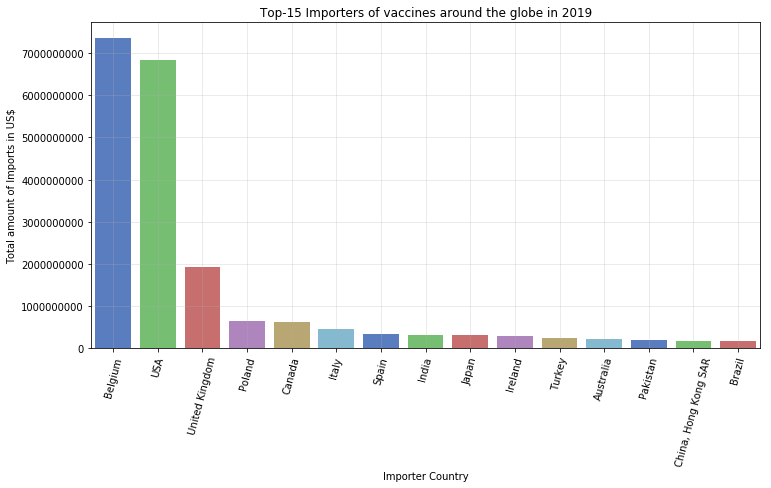

In [26]:
plotTopnCountries(df=top_importers_2019, feature='Trade Value (US$)',
                      topn=topn, kind='Import', year=year)

Its interesting that except the firt three countries (Belgium, USA, UK), the rest of the countries seem to import much less compared with the top-3 importers. 

## Part 3 - Main analysis

In this part we are going to focus only at the top-3 importers of vaccines and perform an in depth analysis about the countries that they are trading with, attempting to identify interesting patterns in the results. This is going to be done in two different parts. In the first part we will focus in the variations of imports by month, i.e. we will create Time Series objects for each country where each observation will be the the Total Value of imports in a specific time point. The second part will focus on Network Analysis.

### Time Series

First we are creating the objects that will contain all the information that we need for our analysis. Each object is going to represent a country and in our analysis, as we mentioned previously, we will focus on Belgium, USA and United Kingdom. All of these countries will be assigned the class **VaccinesTradeNetwork** which is a class that will allow us to create our analysis without having to include the code snipets in the notebook. If you want more information regarding how this class is organized, feel free to have a look at the repository.

In [37]:
# Create an object for Belgium 
belgium = VaccinesTradeNetwork(df, country='Belgium')
belgium_imports_df = belgium.createFlowDF(tradeflow='Imports', source='Reporter', target='Partner')

# Create an object for USA 
usa = VaccinesTradeNetwork(df, country='USA')
usa_imports_df = usa.createFlowDF(tradeflow='Imports', source='Reporter', target='Partner')

# Create an object for United Kingdom 
united_kingdom = VaccinesTradeNetwork(df, country='UK')
united_kingdom_imports_df = united_kingdom.createFlowDF(tradeflow='Imports', source='Reporter', target='Partner')

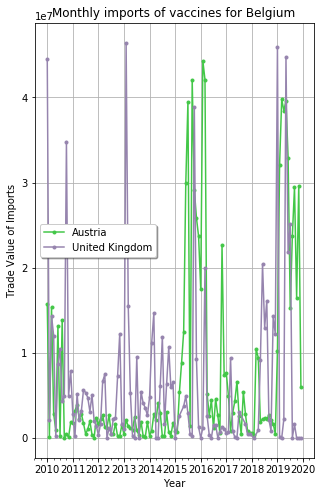

In [39]:
belgium.plotTimeSeries(partner_list=['Austria', 'United Kingdom'], timeframe='month')